In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Split Data Train and Test
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

#Modelling
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
redwine = pd.read_csv('winequality-red.csv')
redwine.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1062,7.7,0.61,0.18,2.4,0.083,6.0,20.0,0.9963,3.29,0.6,10.2,6


In [3]:
redwine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1596 non-null   float64
 1   volatile acidity      1596 non-null   float64
 2   citric acid           1596 non-null   float64
 3   residual sugar        1596 non-null   float64
 4   chlorides             1596 non-null   float64
 5   free sulfur dioxide   1596 non-null   float64
 6   total sulfur dioxide  1596 non-null   float64
 7   density               1596 non-null   float64
 8   pH                    1596 non-null   float64
 9   sulphates             1596 non-null   float64
 10  alcohol               1596 non-null   float64
 11  quality               1596 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 149.8 KB


In [4]:
redwine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000
mean,8.314160,0.527954,0.270276,2.535558,0.087120,15.858396,46.382206,0.996744,3.311917,0.656385,10.421147,5.637218
std,1.732203,0.179176,0.193894,1.405515,0.045251,10.460554,32.839138,0.001888,0.153346,0.163057,1.060371,0.807080
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996745,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997833,3.400000,0.730000,11.100000,6.000000
max,15.600000,1.580000,0.790000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.000000,8.000000


<Axes: xlabel='density', ylabel='alcohol'>

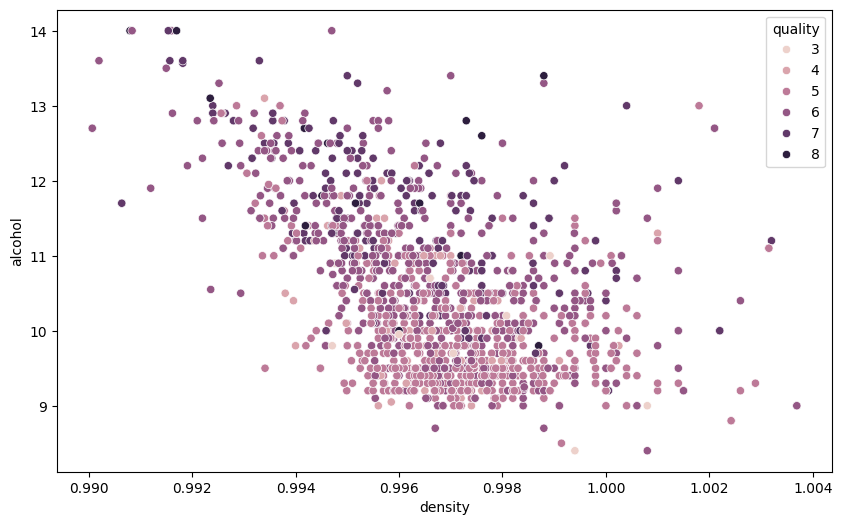

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='density', y='alcohol', data= redwine, hue='quality')

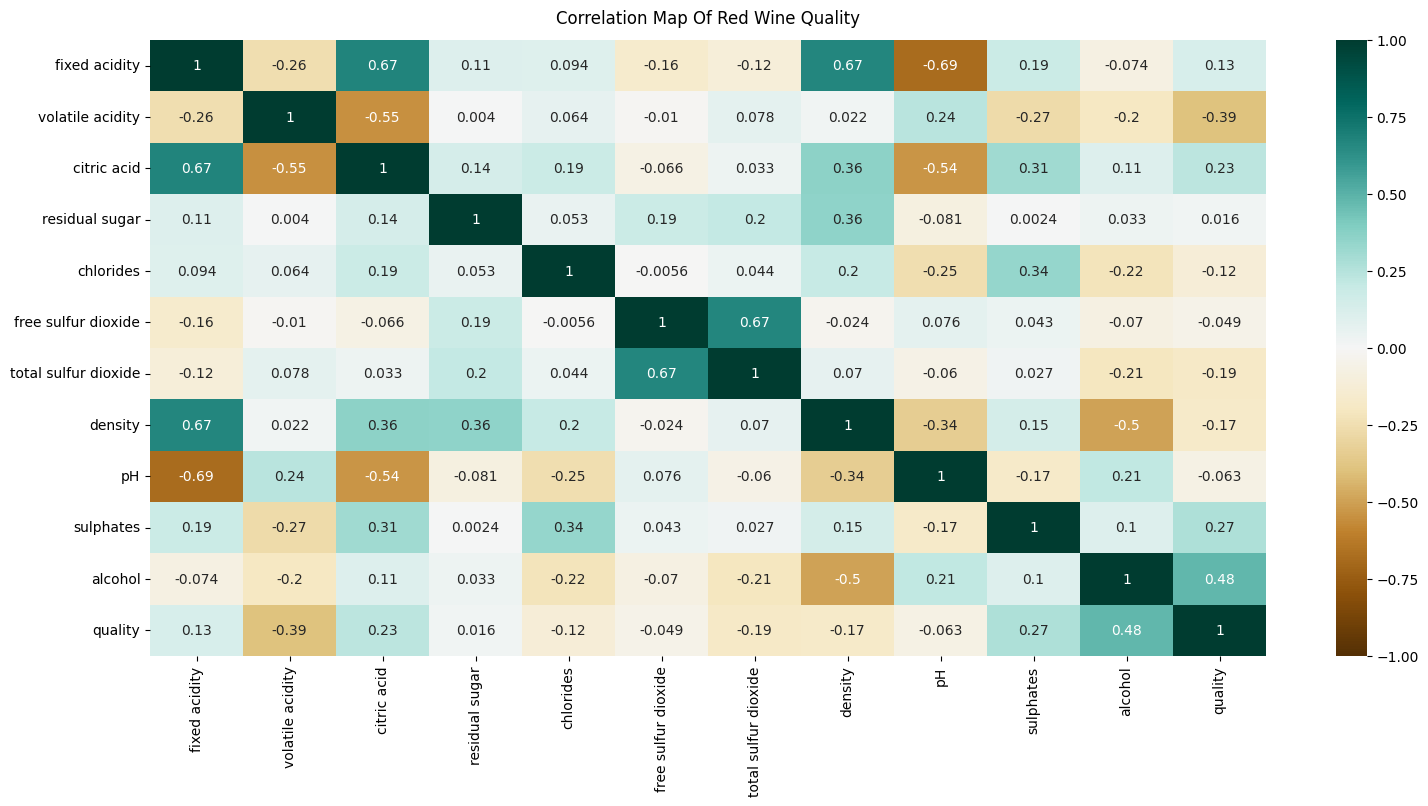

In [6]:
plt.figure(figsize=(18, 8))
sns.heatmap(redwine.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('Correlation Map Of Red Wine Quality', fontdict={'fontsize':12}, pad=12);

In [7]:
redwine['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [8]:
redwine['quality'] = np.where(redwine['quality'] > 6, 1, 0)
redwine['quality'].value_counts()

quality
0    1379
1     217
Name: count, dtype: int64

In [9]:
X = redwine.drop(['quality'], axis = 1)
y = redwine['quality']

In [10]:
X.shape

(1596, 11)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.3, random_state = 1111)

In [12]:
k = range(1,50,2)
testing_accuracy = []
training_accuracy = []
score = 0

for i in k:
    knn = KNeighborsClassifier(n_neighbors = i)
    pipe_knn = Pipeline([('scale', MinMaxScaler()), ('knn', knn)])
    pipe_knn.fit(X_train, y_train)
    
    y_pred_train = pipe_knn.predict(X_train)
    training_accuracy.append(accuracy_score(y_train, y_pred_train))
    
    y_pred_test = pipe_knn.predict(X_test)
    acc_score = accuracy_score(y_test,y_pred_test)
    testing_accuracy.append(acc_score)
    
    if score < acc_score:
        score = acc_score
        best_k = i
        
print('Best Accuracy Score', score, 'Best K-Score', best_k)

Best Accuracy Score 0.9164926931106472 Best K-Score 1


In [13]:
knn = KNeighborsClassifier(n_neighbors = 3)
pipe_knn = Pipeline([('scale', MinMaxScaler()), ('knn', knn)])
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [14]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

pipe_knn_cv = model_evaluation(pipe_knn, 'roc_auc')

score_mean = [pipe_knn_cv.mean()]
score_std = [pipe_knn_cv.std()]
score_roc_auc = [roc_auc_score(y_test, pipe_knn.predict(X_test))]
method_name = ['K-Neighbors Classifier']
summary = pd.DataFrame({'method': method_name, 'mean score': score_mean,
                        'std score': score_std, 'roc auc score': score_roc_auc})
summary

,method,mean score,std score,roc auc score
0,K-Neighbors Classifier,0.771226,0.017401,0.749907


In [15]:
knn = KNeighborsClassifier(n_neighbors = 3)
estimator = Pipeline([('scale', MinMaxScaler()), ('knn', knn)])

hyperparam_space = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
    'knn__leaf_size': [10, 20, 30, 40, 50],
    'knn__weights': ['uniform', 'distance']
}

grid = GridSearchCV(
                estimator,
                param_grid = hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'roc_auc',
                n_jobs = -1)

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=3))]),
             n_jobs=-1,
             param_grid={'knn__leaf_size': [10, 20, 30, 40, 50],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [16]:
print('best score', grid.best_score_)
print('best param', grid.best_params_)

best score 0.8857997660036772
best param {'knn__leaf_size': 10, 'knn__n_neighbors': 17, 'knn__weights': 'distance'}


In [17]:
estimator.fit(X_train, y_train)
y_pred_estimator = estimator.predict(X_test)
print(classification_report(y_test, y_pred_estimator))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       414
           1       0.69      0.54      0.60        65

    accuracy                           0.90       479
   macro avg       0.81      0.75      0.77       479
weighted avg       0.90      0.90      0.90       479



In [18]:
grid.best_estimator_.fit(X_train, y_train)
y_pred_grid = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       414
           1       0.78      0.49      0.60        65

    accuracy                           0.91       479
   macro avg       0.85      0.74      0.78       479
weighted avg       0.91      0.91      0.90       479



In [19]:
score_list = [roc_auc_score(y_test, y_pred_estimator), roc_auc_score(y_test, y_pred_grid)]
accuracy = [score, accuracy_score(y_test, y_pred_grid)]
method_name = ['K-Neighbors Classifier Before Tuning', 'K-Neighbors Classifier After Tuning']
best_summary = pd.DataFrame({
    'method': method_name,
    'roc auc score': score_list,
    'accuracy score': accuracy
})
best_summary

,method,roc auc score,accuracy score
0,K-Neighbors Classifier Before Tuning,0.749907,0.916493
1,K-Neighbors Classifier After Tuning,0.735284,0.912317
